In [5]:
video_id = 'yQqthbvYE8M'
output_filename = 'TED_MARCH2022_Ukraine_War_Could_Change_Everything_Yuval_Noah_Harari'

# SELENIUM

In [ ]:
# !pip install webdriver-manager

In [10]:
import selenium

In [73]:
import json # for saving html
import os #for checking if file exists

# selenium 4
from selenium import webdriver
#manager:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.chrome.options import ChromiumOptions

class Hardcoded:
    """This class stores all the xpaths and links that are 
    currently used to get youtube comments, but may change in the future.
    """
    BASE_YOUTUBE_URL = 'https://www.youtube.com/watch?v='
    
    COOKIES_POPUP_PATH = '//ytd-consent-bump-v2-lightbox/tp-yt-paper-dialog'
    COOKIES_AGREE_PATH = "//*[contains(@aria-label,'Agree to the use of cookies')]"

    #for pausing autoplay
    VIDEO_PLAYER_PATH = "//div[@id='movie_player']"
    
    #for video stats + info:
    # DEPENDING ON THE FORMAT YOUTUBE SUPPLIES, THIS ONE GET RAW HTML (NO DETAIL EXTRACTED YET)
    VIDEO_METADATA_PATH = "//ytd-watch-metadata"
    DESCRIPTION_PATH = "//div[@id='description']"
    DESCRIPTION_MORE_PATH = "//tp-yt-paper-button[@id='more']"
    
    # DEPENDING ON THE FORMAT YOUTUBE SUPPLIES, THIS ONE GETS FULL DETAILS
    VIDEO_TITLE_PATH = "//ytd-video-primary-info-renderer/div[@id='container']/h1"
    _DESC_LOC_PATH_ = "//div[@id='meta-contents']/ytd-video-secondary-info-renderer/div[@id='container']/ytd-expander"
    VIDEO_DESC_TEXT_PATH = _DESC_LOC_PATH_ + "/div[@id='content']/div[@id='description']/yt-formatted-string"
    VIDEO_EXPAND_DESC_BTN_PATH = _DESC_LOC_PATH_ + "/tp-yt-paper-button[@id='more']"
    VIDEO_VIEWS_CLASS = "view-count"
    VIDEO_LIKES_PATH = "//*[contains(@aria-label,' likes')]" #use .get_attribute('aria-label')
    VIDEO_DISLIKES_PATH = "//*[contains(@aria-label,' dislikes')]" 
    VIDEO_TOTAL_COMMENTS_PATH = "//*[starts-with(@class,'count-text')]"
    PARENT_PATH = "parent::*"
    AUTHOR_PATH = "//*[contains(@class,'ytd-channel-name')]" #href=channel url, .text = channel name
    AUTHOR_CHANNEL_URL = "//ytd-video-owner-renderer/a"
    AUTHOR_SUB_COUNT_PATH = "//*[@id='owner-sub-count']" #aria-label = num subscribers
    
    #for sorting comments
    SORT_COMMENTS_DROPDOWN_PATH = "//tp-yt-paper-button[@aria-label='Sort comments']"
    SORT_COMMENTS_DESELECTED_PATH = "//a[@aria-selected='false']" 
    INDIVIDUAL_COMMENT_PATH = "//ytd-comment-thread-renderer"
    
    #for loading more comments
    COMMENT_PAGINATOR_PATH = "//ytd-continuation-item-renderer"
    COMMENT_PAGINATOR_SPINNER_PATH = COMMENT_PAGINATOR_PATH + "/tp-yt-paper-spinner"  #aria-hidden='true'
    COMMENT_RENDERER_BLOCK_PATH = "//ytd-item-section-renderer[@id='sections']"
    
    SET_COMMENT_EXTRACTION_ABSOLUTE_MAX = 1*10**9 #(1 billion)
    
def handle_cookies_popup(driver_):
    """Accepts the cookies policy if it is blocking the page
    """
    try:
        pageload = WebDriverWait(driver_, 5).until(
        EC.presence_of_element_located(
            (By.XPATH, Hardcoded.COOKIES_POPUP_PATH)
        ))
        cookies_popup = driver_.find_element(
            By.XPATH, Hardcoded.COOKIES_POPUP_PATH)
        
        if cookies_popup.is_displayed():
            print('Handling cookies popup...')
            
            accept_cookies_btn = cookies_popup.find_element(
                By.XPATH, Hardcoded.COOKIES_AGREE_PATH)
            print('... agree button found')
            
            accept_cookies_btn.click()
            print('... Cookies popup has been agreed to!\n')
            return
    except:
        return
    
def pause_autoplay(driver_):
    """Pauses video that autoplays within 10 seconds of page loading.
    """
    print('Overriding Autoplay...\n')
    wait_till_video_playing = WebDriverWait(driver_, 10).until(
        EC.text_to_be_present_in_element_attribute(
            (By.XPATH, Hardcoded.VIDEO_PLAYER_PATH),
            'class','playing-mode'
        ))
    driver_.find_element(
        By.XPATH, Hardcoded.VIDEO_PLAYER_PATH
    ).click()
    return

def get_video_detail(driver_):
    """Returns the video name and description, number of views/likes/dislikes/comments
    """
    def get_title(driver_):
        print('\tgetting video title...')
        video_title = driver_.find_element(By.XPATH, Hardcoded.VIDEO_TITLE_PATH).text
        return video_title
    
    def get_views(driver_):
        print('\tgetting current view count...')
        video_views = driver_.find_element(By.CLASS_NAME,Hardcoded.VIDEO_VIEWS_CLASS).text
        return video_views

    def get_likes(driver_):
        print('\tgetting current likes count...')
        video_likes = driver_.find_element(By.XPATH, Hardcoded.VIDEO_LIKES_PATH).get_attribute('aria-label')
        return video_likes
    
    def get_dislikes(driver_):
        print('\tgetting current dislikes count...')
        video_dislikes = driver_.find_element(By.XPATH, Hardcoded.VIDEO_DISLIKES_PATH).get_attribute('aria-label')
        return video_dislikes
    
    def get_description(driver_):
        print("\tgetting video description...")
        btn_path = Hardcoded.VIDEO_EXPAND_DESC_BTN_PATH
        btn = driver_.find_element(By.XPATH, btn_path)
        
        # scroll to dropdown
        driver_.execute_script("arguments[0].scrollIntoView({block:'center'});", btn)
        
        if btn.is_displayed():
            print('...expanding description to get full text')
            btn.click()
        else:
            pass
        
        wait_till_desc_loaded = WebDriverWait(driver_, 10).until(
                EC.element_to_be_clickable(
                    (By.XPATH, btn_path.replace("id='more'","id='less'"))
                ))
        video_desc = driver_.find_element(By.XPATH, Hardcoded.VIDEO_DESC_TEXT_PATH).text
        return video_desc
    
    def get_comment_count(driver_):
        """Returns the current total comments count from the video.
        
        note this scrolls down to the comments section, which also loads the box
         for sorting comments by Newest First, which is needed for the next part.
        """
        print('\tgetting comment count')
        #scroll to load first batch of comments
        comments_section = WebDriverWait(driver_, 30).until(
            EC.presence_of_element_located(
                (By.ID, "comments")
            ))
        driver_.execute_script("arguments[0].scrollIntoView();", comments_section)
        ensure_fullyloaded = WebDriverWait(driver_, 30).until(
            EC.presence_of_element_located(
                (By.XPATH, Hardcoded.VIDEO_TOTAL_COMMENTS_PATH)
            ))
        num_comments = driver_.find_element(
            By.XPATH, Hardcoded.VIDEO_TOTAL_COMMENTS_PATH
        ).text
        return num_comments
    
    detail_fncs = {
        'video_title':get_title, 
        'video_views':get_views, 
        'video_likes':get_likes, 
        'video_dislikes':get_dislikes, 
        'video_desc':get_description,
        'video_num_comments':get_comment_count
    }
    # run all the 6 functions above and save this video metadata to a dictionary
    video_details = {}
    for fnc_name, fnc in detail_fncs.items():
        try:
            video_details[fnc_name] = fnc(driver_)
        except:
            print(f'Failed to extract {fnc_name}')
        
    return video_details

def get_author_detail(driver_):
    """Returns video uploader name, their channel url, their number of subscribers
    """
    def get_author_name(driver_):
        print("\tgetting video author...")
        author_name = driver_.find_element(
            By.XPATH, Hardcoded.AUTHOR_PATH).text
        return author_name
    
    def get_author_url(driver_):
        print("\tgetting video author url...")
        author_url = driver_.find_element(
            By.XPATH, Hardcoded.AUTHOR_CHANNEL_URL).get_attribute('href')
        return author_url
    
    def get_author_subcount(driver_):
        print("\tgetting video author subscriber count...")
        author_subs = driver_.find_element(
            By.XPATH, Hardcoded.AUTHOR_SUB_COUNT_PATH).get_attribute('aria-label')
        return author_subs
    
    author_details = {
        'author_name':get_author_name(driver_),
        'author_url':get_author_url(driver_),
        'author_subs':get_author_subcount(driver_)
    }
    return author_details

def get_metadata(driver_):
    """This function gets all the video details from other functions."""
    print('Getting Video Metadata:\n')
    metadata = {}
    
    print('...expanding description to get full text')
    md_elem = driver_.find_element(By.XPATH, Hardcoded.VIDEO_METADATA_PATH)
    
    if not md_elem.is_displayed():
        print('Getting Video Metadata:\n')
        metadata = {}
        metadata.update(get_video_detail(driver_))
        if len(metadata.keys()) < 6:
            print("missing some of the metadata")
            md_elem = driver_.find_element(By.XPATH, Hardcoded.VIDEO_METADATA_PATH)
            metadata[driver_.current_url] = md_elem.get_attribute("innerHTML")
        else:
            pass
        
        metadata.update(get_author_detail(driver_))
        return metadata
    
    else:
        print("Couldn't extract metadata, you will need to do this manually later.")
    
        # scroll to dropdown
        driver_.execute_script("arguments[0].scrollIntoView({block:'center'});", metadata_element)

        try:
            exp_desc_elem = md_elem.find_element(By.XPATH, Hardcoded.DESCRIPTION_PATH
                                                ).find_element(By.XPATH, Hardcoded.DESCRIPTION_MORE_PATH)

            if exp_desc_elem.is_displayed():
                exp_desc_elem.click()

            while driver_.find_element(By.XPATH, Hardcoded.VIDEO_METADATA_PATH
                                      ).find_element(By.XPATH, Hardcoded.DESCRIPTION_PATH
                                                    ).find_element(By.XPATH, Hardcoded.DESCRIPTION_MORE_PATH
            ).is_displayed():
                WebDriverWait(driver_,1)
        except:
            pass

        md_elem = driver_.find_element(By.XPATH, Hardcoded.VIDEO_METADATA_PATH)
        metadata[driver_.current_url] = md_elem.get_attribute("innerHTML")
        return metadata

def sort_comments(driver_,sort_choice='Newest first'):
    """Either sort by 'Newest first' or by 'Top comments'
    Newest first - for repeat scraping of the same video over time
    Top comments - for when you only want a sample of comments per video
    """    
    if sort_choice not in ["Newest first","Top comments"]:
        print("Error: sort_choice is case sensitive, choose from 'Newest first' and 'Top comments'")
    
    print(f"Sorting Comments by {sort_choice}")
    
    # scroll to load first batch of comments
    comments_section = WebDriverWait(driver_, 30).until(
        EC.presence_of_element_located(
            (By.ID, "comments")
        ))
    
    driver_.execute_script("arguments[0].scrollIntoView({block:'center'});",
                           comments_section)
    
    wait_till_first_cmt_loaded = WebDriverWait(driver_, 30).until(
        EC.presence_of_element_located(
            (By.XPATH, Hardcoded.INDIVIDUAL_COMMENT_PATH)
        ))
    
    dropdown_elem = driver_.find_element(
        By.XPATH, Hardcoded.SORT_COMMENTS_DROPDOWN_PATH)

    # expand the sort options dropdown
    if dropdown_elem.get_attribute('aria-expanded')=='false':

          # scroll to dropdown
        driver_.execute_script("arguments[0].scrollIntoView({block:'center'});",
                               dropdown_elem)

        wait_till_clickable = WebDriverWait(driver_, 10).until(
            EC.element_to_be_clickable(dropdown_elem))

        dropdown_elem.click()

        # wait for dropdown options to load
        wait_till_loaded = WebDriverWait(driver_, 10).until(
            EC.text_to_be_present_in_element_attribute(
                (By.XPATH, Hardcoded.SORT_COMMENTS_DROPDOWN_PATH),
                'aria-expanded','true'))
    
    # find the sort options buttons
    dropdown_elem = driver_.find_element(
        By.XPATH, Hardcoded.SORT_COMMENTS_DROPDOWN_PATH)

    # scroll to dropdown
    driver_.execute_script("arguments[0].scrollIntoView({block:'center'});",
                           dropdown_elem)
    
    wait_till_dropdown_loads = WebDriverWait(driver_,10).until(
        EC.element_to_be_clickable(
            (By.LINK_TEXT, sort_choice)
        ))
    
    comments_sorter = driver_.find_element(
        By.LINK_TEXT, sort_choice
    ).get_attribute('class')
    
    print('comments sorter',comments_sorter)
    
    if 'iron-selected' in comments_sorter:
        #reclose dropdown if your preference is already selected.
        
        dropdown_elem = driver_.find_element(
            By.XPATH, Hardcoded.SORT_COMMENTS_DROPDOWN_PATH)
        
        dropdown_elem.click()
        pass
    
    else:    
        deselected_option = dropdown_elem.find_element(
            By.XPATH, Hardcoded.SORT_COMMENTS_DESELECTED_PATH)
    
        deselected_option.click()
    
        wait_till_comments_reload = WebDriverWait(driver_, 10).until(
            EC.presence_of_element_located(
                (By.XPATH, Hardcoded.INDIVIDUAL_COMMENT_PATH)
            ))
    return

def get_comments(driver_, max_comments=None):
    """Scrolls down to load more comments until you have seen them all"""
    if type(max_comments) == type(None):
        max_comments = Hardcoded.SET_COMMENT_EXTRACTION_ABSOLUTE_MAX
        
    current_comment_elements = driver_.find_elements(
        By.XPATH, Hardcoded.INDIVIDUAL_COMMENT_PATH
    )
    visible_comments = len(current_comment_elements)

    while visible_comments <= max_comments:
        print(f"Pre-scroll count = {visible_comments}")

        driver_.execute_script("arguments[0].scrollIntoView();",
                               current_comment_elements[-1]) #yt_paginator_element)
        
        stage_failed = ''
        try:
            # spinner element is present when the ajax? request is being made
            stage_failed = 'wait_till_request_made'
            wait_till_request_made = WebDriverWait(driver_, 10).until(
                EC.text_to_be_present_in_element_attribute(
                    (By.XPATH, Hardcoded.COMMENT_PAGINATOR_SPINNER_PATH),
                    'aria-hidden','true'))

            try:
                num_comments_before = visible_comments
                # the attribute 'can-show-more' only appears when comments are rendering
                stage_failed = 'wait_till_render_start'
                wait_till_render_start = WebDriverWait(driver_, 3).until(
                    EC.element_attribute_to_include(
                        (By.XPATH, Hardcoded.COMMENT_RENDERER_BLOCK_PATH),
                        'can-show-more'))
                
            except:
                # recount comments now
                stage_failed = 'current_comment_elements'
                current_comment_elements = driver_.find_elements(
                    By.XPATH, Hardcoded.INDIVIDUAL_COMMENT_PATH)
                visible_comments = len(current_comment_elements)
                
                if num_comments_before < visible_comments:
                    pass
                else:
#                     print()
                    raise Error('issue loading more commments')
              
#             OLD VERSION: before TRY EXCEPT, I think the page loaded so fast the python missed the 'can-show-more' appearing
                #the new way above recounts the comments and checks if more have loaded or not before raising the error
#             # the attribute 'can-show-more' only appears when comments are rendering
#             stage_failed = 'wait_till_render_start'
#             wait_till_render_start = WebDriverWait(driver_, 20).until(
#                 EC.element_attribute_to_include(
#                     (By.XPATH, Hardcoded.COMMENT_RENDERER_BLOCK_PATH),
#                     'can-show-more'))
            
            # wait for 'can-show-more' to disappear
            stage_failed = 'wait_till_render_end'
            wait_till_render_end = WebDriverWait(driver_, 20).until_not(
                EC.element_attribute_to_include(
                    (By.XPATH, Hardcoded.COMMENT_RENDERER_BLOCK_PATH),
                    'can-show-more'))

            # recount comments now
            stage_failed = 'current_comment_elements'
            current_comment_elements = driver_.find_elements(
                By.XPATH, Hardcoded.INDIVIDUAL_COMMENT_PATH)
            visible_comments = len(current_comment_elements)

        except:
            if stage_failed != '':
                print(f'Failed at stage: {stage_failed}')
                
            # NOTE: this exception will occur when the comments are all loaded.
            total_comments = [x.get_attribute("innerHTML") for x in current_comment_elements]

            print(f'\nWe read a total of {visible_comments} comments')
            return total_comments
    
    print(f'Returning {max_comments} which is the limit set in the function. You can adjust this.')
    limited_comments = current_comment_elements[:max_comments]
    limited_comments = [x.get_attribute("innerHTML") for x in limited_comments]
    return limited_comments

def save_json_output(filename_, metadata_dict,comments_list):
    if os.path.exists(filename_):
        print('you already had a file saved, not yet set up to append. Exiting.')
        return
    else:
        data = metadata_dict
        data['comments_soup'] = comments_list
        
        #load beautiful soup
        if 'bs4' not in locals():
            import bs4
            
        try:
            extracted_comments_text = [
                bs4.BeautifulSoup(soup).find('yt-formatted-string',
                                             {'id':'content-text'}
                                            ).get_text() for soup in data['comments_soup']
            ]
            data['comments_text'] = extracted_comments_text
            
        except:
            data['comments_text'] = ['not extracted yet from soup']
            print("couldn't extract comment text, saved as raw html list instead")
            
        with open(f'{filename_}.json','a') as f:
            f.write(json.dumps(data))
        
        return data


In [264]:
def get_youtube_video_comments(video_id_, output_filename_, sort_comments_by="Newest first"):
    if os.path.exists(output_filename_):
#         probably only a few tweaks to the function save_json_output needed to append new data
# AND also the get_comments function should stop loading comments when it reaches any comments taken from the past, when sorted by newest first.
        return print('you have already scraped this video. this is not yet set up to run repeat scraping')
    else:
#         opt = ChromiumOptions()
#         opt.add_argument("--headless")
#         opt.add_argument("--blink-settings=imagesEnabled=false")
#         with webdriver.Chrome(options=opt) as browser:
#         with webdriver.Chrome() as browser:

#         old version:  note some expected conditions don't work. you may need to downgrade selenium
#         with webdriver.Chrome(os.path.abspath(os.getcwd()) + '/chromedriver') as browser:



#         new version using webdriver manager, so you don't need to download the driver
        with webdriver.Chrome(service=Service(ChromeDriverManager().install())) as browser:

        
        
            video_url = Hardcoded.BASE_YOUTUBE_URL + video_id_
            browser.get(video_url)

            handle_cookies_popup(browser)
            pause_autoplay(browser)

            video_metadata = get_metadata(browser)

            sort_comments(browser,sort_choice=sort_comments_by)

            video_comments = get_comments(browser, max_comments=None)
            
            print('\n\t | Closing browser. |')

            data = save_json_output(output_filename_, video_metadata, video_comments)

        print("\n-- Finished! --\n")
        return data

def extract_comment_details_and_save_dfs(data_):
    """cleans up output from scraper and extracts comment text and details
    
    input: data dictionary (output from get_youtube_video_comments)
    output: 2 csv files VideoMetadata + Comments
    
    Tip: do not pass the get_youtube_video_comments function directly into here, 
    save it as a variable first you you don't need to run the scraper again
    
    """
    def get_rel_time(time_text):
        """converts time strings to dates if possible.
        Tries to interpret written text of time and generate a timestamp for each comment
        
        e.g. '8 days ago' becomes datetime.now() - timedelta(days=8) 
        
        """

        from datetime import datetime
        from datetime import timedelta

        time_of_extraction = datetime.now()

        # mins ago/ moments ago/ just now
        if 'just now' in time_text.lower():
            return time_of_extraction

        elif 'moments ago' in time_text.lower():
            return time_of_extraction

        elif ('mins' in time_text.lower()) or ('minutes' in time_text.lower()):
            return datetime.now()

        elif ('secs' in time_text.lower()) or ('seconds' in time_text.lower()):
            return datetime.now()

        elif 'minutes ago' in time_text.lower():
            offset_hours = time_text.split(' ')[0]
            return datetime.now() - timedelta(hours=int(offset_hours))

        #hours ago
        elif 'hours ago' in time_text.lower():
            offset_hours = time_text.split(' ')[0]
            return datetime.now() - timedelta(hours=int(offset_hours))

        elif 'hour ago' in time_text.lower():
            return datetime.now() - timedelta(hours=1)

        elif 'past hour' in time_text.lower():
            return datetime.now() - timedelta(hours=1)

        #days ago
        elif 'days ago' in time_text.lower():
            if 'a few' in time_text.lower():
                return datetime.now() - timedelta(days=3)
            else:
                offset_days = time_text.split(' ')[0]
                return datetime.now() - timedelta(days=int(offset_days))

        elif 'day ago' in time_text.lower():
            return datetime.now() - timedelta(days=1)

        elif 'yesterday' in time_text.lower():
            return datetime.now() - timedelta(days=1)

        #weeks ago
        elif 'weeks ago' in time_text.lower():
            if 'a few' in time_text.lower():
                return datetime.now() - timedelta(days=3*7)
            else:
                offset_days = time_text.split(' ')[0]
                return datetime.now() - timedelta(days=int(offset_days))

        elif 'week ago' in time_text.lower():
            return datetime.now() - timedelta(days=7)

        elif 'last week' in time_text.lower():
            return datetime.now() - timedelta(days=7)

        #months ago
        elif 'months ago' in time_text.lower():
            if 'a few' in time_text.lower():
                return datetime.now() - timedelta(months=3)
            else:
                offset_months = time_text.split(' ')[0]
                return datetime.now() - timedelta(months=int(offset_months))

        elif 'month ago' in time_text.lower():
            return datetime.now() - timedelta(months=1)

        elif 'last month' in time_text.lower():
            return datetime.now() - timedelta(months=1)

        #years ago
        elif 'years ago' in time_text.lower():
            offset_years = time_text.split(' ')[0]
            return datetime.now() - timedelta(years=int(offset_years))

        elif 'year ago' in time_text.lower():
            return datetime.now() - timedelta(years=1)

        else:
            return time_text
    
    #load beautiful soup
    if 'bs4' not in locals():
        import bs4
    
    #load pandas
    if 'pd' not in locals():
        import pandas as pd
            
    #get comments
    print('extracting comments text')
    extracted_comments_text = [
                    bs4.BeautifulSoup(soup).find('yt-formatted-string',
                                                 {'id':'content-text'}
                                                ).get_text() for soup in data_['comments_soup']
                ]

    #get comment author
    print('extracting comments authors')
    author_channel = [bs4.BeautifulSoup(soup).find('a',{'id':'author-text'}
                                )['href'] for soup in data_['comments_soup']
                ]
    author_name = [bs4.BeautifulSoup(soup).find('a',{'id':'author-text'}
                                               ).get_text().strip() 
                   for soup in data_['comments_soup']
                ]

    #get comment likes
    print('extracting comments likes count')
    comment_likes_block = [[span['aria-label'] if (
        'aria-label' in span.attrs
        ) else '0' for span in bs4.BeautifulSoup(soup).find_all(
                'span',{'id':'vote-count-left'})
            ][0] for soup in data_['comments_soup']
          ]
    comment_likes = ['0' if (
        x=='0') else x.split(' ')[0] if (
        ' like' in x) else '-'+x.split(' ')[0] if (
        ' dislike' in x) else x for x in comment_likes_block
    ]

    #get comment time (TEXT)
    print('extracting comments approx time/day')
    time_of_extraction = datetime.now()

    relative_comment_time = [bs4.BeautifulSoup(soup).find(
        'yt-formatted-string',{'class':'published-time-text'}
        ).get_text().strip() for soup in data_['comments_soup']
                            ]
    get_approx_comment_time = list(pd.Series(relative_comment_time).apply(get_rel_time))


    # get num replies
    print('extracting comments replies count')
    reply_num_text = [
        [btn['aria-label'] for btn in bs4.BeautifulSoup(soup).find_all(
            'tp-yt-paper-button',{'aria-disabled':'false'}
        ) if 'aria-label' in btn.attrs]
     for soup in data_['comments_soup']]

    replies_count = [int(x[-1].lower().replace('hide','').replace('replies','').strip()) if (
        'Hide' in x[-1] and 'replies' in x[-1]
        ) else 1 if (
        'Hide' in x[-1] and 'reply' in x[-1]
        ) else 0 for x in reply_num_text]

    #CONVERT TO DATAFRAMES
    print('converting to dataframe')
    for_dataframe = {}
    for_dataframe['time_of_extraction'] = time_of_extraction
    for_dataframe['relative_comment_time'] = relative_comment_time
    for_dataframe['get_approx_comment_time'] = get_approx_comment_time
    for_dataframe['author_name'] = author_name
    for_dataframe['author_channel'] = author_channel
    for_dataframe['comment_likes'] = comment_likes
    for_dataframe['replies_count'] = replies_count
    for_dataframe['comments'] = extracted_comments_text

    
    #DATAFRAME SECTION:
    
    comments_df = pd.DataFrame(for_dataframe)
    
    #convert LIKES STRING into numeric
    print('converting comment likes string to numeric')
    try:
        comments_df.comment_likes = (comments_df.comment_likes.replace(r'[KM]+$', '', regex=True).astype(float) \
            * comments_df.comment_likes.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1) \
                .replace(['K','M'], [10**3, 10**6]).astype(int))
    except:
        print("couldn't convert comment_likes to numbers")
        pass

    metadata_df = pd.DataFrame([
        data_['video_title'],
        data_['author_name'],
        data_['author_url'],
        data_['author_subs'],
        data_['video_views'],
        data_['video_likes'],
        data_['video_desc'],
        data_['video_num_comments']
        ], index=[
        'video_title',
        'author_name',
        'author_url',
        'author_subs',
        'video_views',
        'video_likes',
        'video_desc',
        'video_num_comments'
        ], columns=['Video Metadata']
    )
    
    print('saving dataframes to files...')
    file_output_name = metadata_df['Video Metadata']['author_name'][:25] + ' _ ' + metadata_df['Video Metadata']['video_title'][:25]
    print('..saving comments_df')
    comments_df.to_csv('video_comments' + file_output_name + '.csv', index=False)
    print('..saving metadata_df')
    metadata_df.to_csv('video_metadata' + file_output_name + '.csv', index=True)
    
    print('\n----\nComplete.')
    return 


AttributeError: module 'selenium.webdriver.support.expected_conditions' has no attribute 'text_to_be_present_in_element_attribute'
    
    
    
    

In [76]:
# actual scraper:

data = get_youtube_video_comments(video_id_=video_id, output_filename_=output_filename, sort_comments_by="Top comments")







====== WebDriver manager ======
Current google-chrome version is 99.0.4844
Get LATEST chromedriver version for 99.0.4844 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/99.0.4844.51/chromedriver_mac64.zip
Driver has been saved in cache [/Users/george.goldberg/.wdm/drivers/chromedriver/mac64/99.0.4844.51]


Handling cookies popup...
... agree button found
... Cookies popup has been agreed to!

Overriding Autoplay...

Getting Video Metadata:

...expanding description to get full text
Getting Video Metadata:

	getting video title...
	getting current view count...
	getting current likes count...
	getting current dislikes count...
Failed to extract video_dislikes
	getting video description...
...expanding description to get full text
	getting comment count
missing some of the metadata
	getting video author...
	getting video author url...
	getting video author subscriber count...
Sorting Comments by Top comments
comments sorter yt-simple-endpoint style-scope yt-dropdown-menu iron-selected
Pre-scroll count = 20
Pre-scroll count = 40
Pre-scroll count = 60
Pre-scroll count = 80
Pre-scroll count = 100
Pre-scroll count = 120
Pre-scroll count = 140
Pre-scroll count = 160
Pre-scroll count = 180
Pre-scroll count = 200
Pre-scroll count = 220
Pre-scroll count = 240
Pre-scroll count = 260
Pre-scroll coun

# extract info from raw html on comments

In [265]:
extract_comment_details_and_save_dfs(data)

extracting comments text
extracting comments authors
extracting comments likes count
extracting comments approx time/day
extracting comments replies count
converting to dataframe
converting comment likes string to numeric
saving dataframes to files...
..saving comments_df
..saving metadata_df

----
Complete.


<AxesSubplot:xlabel='get_approx_comment_time'>

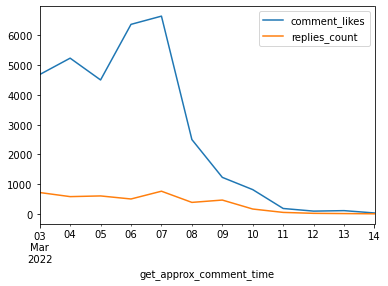

In [277]:
tmp = pd.read_csv("video_commentsTED _ The War in Ukraine Could .csv")
tmp.get_approx_comment_time = pd.to_datetime(tmp.get_approx_comment_time)
tmp.resample('1D', on='get_approx_comment_time').sum().plot()

<AxesSubplot:xlabel='get_approx_comment_time'>

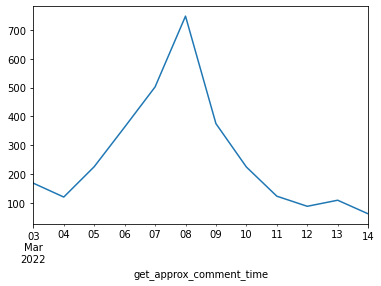

In [279]:
tmp.resample('1D', on='get_approx_comment_time').size().plot()

In [78]:
data.keys()

dict_keys(['video_title', 'video_views', 'video_likes', 'video_desc', 'video_num_comments', 'https://www.youtube.com/watch?v=yQqthbvYE8M', 'author_name', 'author_url', 'author_subs', 'comments_soup', 'comments_text'])

In [80]:
len(data['comments_soup'])

3114

Author: George Goldberg (Nov 2021)

# IF I DID COMMENT REPLIES:

In [ ]:


# #wait for sorting options to load (timeout after 30 seconds)
# xpath_sort_btn = "//tp-yt-paper-button[@aria-label='Sort comments']"
# elem = WebDriverWait(browser, 30).until(
#     EC.presence_of_element_located((By.XPATH, xpath_sort_btn))
#     )

# #PLAN : once sort btn is loaded above, you need to:
# # - set it as an element
# # - click it, or change the attribute 'aria-expanded' from 'false' to 'true' for the link that is attached to the text "Newest First"
# # hopefully, this replaces the current sorting and reloads comments (check visually if the browser has changed)
# # - then wait for EC.presence_of_element_located for 

# COMMENT STRUCTURE:
# comment container tag <ytd-comments id='comments'>
#  --- top level spinner (dont use) <tp-yt-paper-spinner-lite aria-hidden="true" #( or "false" if still loading)
#  --- comment block <ytd-item-section-renderer id='sections'>
#     --- comment header/metadata (total comments, sort dropdown etc) <div id='header'>
#         --- <ytd-comments-header-renderer>
#             --- <div id='title'>
#                 --- <h2 id='count'>.text
# # (from above=TOTAL VIDEO COMMENTS as string:will need to remove "Comments" and strip() and remove commas too and format as number)

#                 --- <span id='sort-menu'>
#                     --- <yt-sort-filter-sub-menu-renderer>
#                         --- <yt-dropdown-menu icon-label='Sort by'>
#                             --- <tp-yt-paper-menu-button>
#                                 --- <div id='trigger'>
#                                     --- <tp-yt-paper-button id='label' role='button' aria-label='Sort comments'> 
# # (use aria-label='Sort comments' as locator here??? as it's quite deep into the html tags)
# # (.click this button above to open the dropdown options)
                                         
#                                 --- <tp-yt-iron-dropdown id='dropdown' aria-hidden='true'> (hidden until dropdown clicked)
#                                     --- <div id='contentWrapper'><div slot='dropdown-content'><tp-yt-paper-listbox id='menu'>
#                                           --- <a aria-selected='true' (also has 'iron-selected' in the class name)
#                                               --- <tp-yt-paper-item role='option'>
#                                                   --- <div class='item'>.text = "Top comments"
#                                           --- <a aria-selected='false'
#                                               --- <tp-yt-paper-item role='option'>
#                                                   --- <div class='item'>.text = "Newest first"
#     --- comment spinner (has 'active' property whilst it is loading/rendering comments.)
#     --- comment contents 
#        |--- first comment <ytd-comment-thread-renderer>
#        |--- second comment <ytd-comment-thread-renderer>
#        |--- ...
#        |--- last rendered comment <ytd-comment-thread-renderer id='comment'>
#             --- comment itself <ytd-comment-renderer>
#                 --- <div id='body'><div id='main'>
#                    |--- <ytd-expander id='expander'>
#                         |--- <div id='content'> <yt-formatted-string id='content-text'>.text
# # (from above=COMMENT TEXT)

#                         |--- tp-yt-paper-button id='less'
#                         |--- <tp-yt-paper-button id='more'> hidden='' 
# # (from above= EXPAND LONGER COMMENTS TO SEE FULL TEXT)
# #             hidden property will be there if the comment can't be expanded.
# #             to get full text: use visiblity_of_element/visiblity_of_element_located/invisiblity_of_element_located/element_to_be_clickable
# #             might be better to save this until the end - save it all THEN expand and resave, incase it breaks and you lose everything
            
#                         |--- <ytd-comment-action-buttons-renderer id='action-buttons'>
#                              --- <div id='toolbar'> <span id="vote-count-left" aria-label='90K likes'> 
# # (from above=COMMENT LIKES: get attribute aria-label from span tag) Then pandas formating to get it as a number:
#     ## pandas regex converting '20K' to float(20000)
#     #     df.comment_likes = (df.comment_likes.replace(r'[KM]+$', '', regex=True).astype(float) \
#     #         * df.comment_likes.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1) \
#     #             .replace(['K','M'], [10**3, 10**6]).astype(int))
                
                
#             --- comment replies div <div id='replies'> 
#                     <ytd-comment-replies-renderer>
#                         <div id='expander'>
#                             |
#                             --- <ytd-button-renderer>
#                                     <a class='yt-simple-endpoint style-scope ytd-button-renderer'>
#                                         <tp-yt-paper-button id='button' role='button' aria-label='View Reply OR View 180 Replies'> 
#                                         (CLICK THIS TO LOAD MORE) + use get_attribute('aria-label') to get the replies count
#                             |
#                             --- <div id='expander-contents'>
#                                  ---<div id='contents'>
                                
#                                    |--- comment reply 1 <ytd-comment-renderer>
#                                         --- <div id='body'><div id='main'>
#                                                  |--- <div id='header'> (reply author + date)
#                                                      --- <div id='header-author'>
#                                                         ---<h3><a id='author-text'> 
# (from above=COMMENT REPLY AUTHOR CHANNEL url from <a>href attribute)
# (from above=COMMENT REPLY AUTHOR NAME from .text either on <h3>.text (use parent xpath locator "parent::*") / <h3><a>.text / <h3><a><span>.text
                                                            
#                                                  |--- <ytd-expander id='expander'> (reply text)
#                                                     |--- <div id='content'>
#                                                         --- <yt-formatted-string id='content-text'> .text 
# (from above=COMMENT REPLY TEXT)
                                                            
#                                                     |--- <tp-yt-paper-button id='less' role="button" hidden="">
#                                                     |--- <tp-yt-paper-button id='more' role="button" hidden=""> If property=hidden, do nothing, else click for replies to this comment reply. 
#                                                  |--- reply date <yt-formatted-string class='published-time-text'>.text
#                                                  |--- reply likes <ytd-comment-action-buttons-renderer id='action-buttons'>
#                                                      --- <div id='toolbar'> <span id="vote-count-left" aria-label='90K likes'> get attribute aria-label
                                                    
#                                     |--- comment reply 2 <ytd-comment-renderer>
#                                     |--- comment reply N
                                        
                                        

#             --- replies block (to a comment) sometimes will be hidden??? <div id="replies" class="style-scope ytd-comment-thread-renderer"><ytd-comment-replies-renderer class="style-scope ytd-comment-thread-renderer"><!--css-build:shady--><div id="expander" class="style-scope ytd-comment-replies-renderer">
#                 |
#                 --- more replies button container
#                     <ytd-button-renderer id="more-replies" class="more-button style-scope ytd-comment-replies-renderer" aria-expanded="false" noink="" use-keyboard-focused="" button-renderer="true" is-paper-button-with-icon="" is-paper-button=""><a class="yt-simple-endpoint style-scope ytd-button-renderer" tabindex="-1"><tp-yt-paper-button id="button" class="style-scope ytd-button-renderer" role="button" tabindex="0" animated="" elevation="0" aria-disabled="false" aria-label="View reply"><!--css-build:shady--><yt-icon class="style-scope ytd-button-renderer"><svg viewBox="0 0 24 24" preserveAspectRatio="xMidYMid meet" focusable="false" class="style-scope yt-icon" style="pointer-events: none; display: block; width: 100%; height: 100%;"><g class="style-scope yt-icon"><path d="M18,9l-6,6L6,9H18z" class="style-scope yt-icon"></path></g></svg><!--css-build:shady--></yt-icon><yt-formatted-string id="text" class="style-scope ytd-button-renderer">View reply</yt-formatted-string></tp-yt-paper-button></a></ytd-button-renderer>
#                 --- fewer replies button container
#                     <ytd-button-renderer id="less-replies" class="less-button style-scope ytd-comment-replies-renderer" aria-expanded="true" noink="" hidden="" use-keyboard-focused="" button-renderer="true" is-paper-button-with-icon="" is-paper-button=""><a class="yt-simple-endpoint style-scope ytd-button-renderer" tabindex="-1"><tp-yt-paper-button id="button" class="style-scope ytd-button-renderer" role="button" tabindex="0" animated="" elevation="0" aria-disabled="false" aria-label="Hide reply"><!--css-build:shady--><yt-icon class="style-scope ytd-button-renderer"><svg viewBox="0 0 24 24" preserveAspectRatio="xMidYMid meet" focusable="false" class="style-scope yt-icon" style="pointer-events: none; display: block; width: 100%; height: 100%;"><g class="style-scope yt-icon"><path d="M18,15H6l6-6L18,15z" class="style-scope yt-icon"></path></g></svg><!--css-build:shady--></yt-icon><yt-formatted-string id="text" class="style-scope ytd-button-renderer">Hide reply</yt-formatted-string></tp-yt-paper-button></a></ytd-button-renderer>
#                 --- expander div (default is hidden - where the replies are rendered when you click for more)
#                     <div id="expander-contents" class="style-scope ytd-comment-replies-renderer" hidden="">
                  
                  
# #     <div id="contents" class="style-scope ytd-comment-replies-renderer"><ytd-continuation-item-renderer class="style-scope ytd-comment-replies-renderer"><!--css-build:shady--><div id="ghost-cards" class="style-scope ytd-continuation-item-renderer"></div>
# # <tp-yt-paper-spinner id="spinner" class="style-scope ytd-continuation-item-renderer" hidden="" aria-hidden="true"><!--css-build:shady--><div id="spinnerContainer" class="active cooldown style-scope tp-yt-paper-spinner"><div class="spinner-layer layer-1 style-scope tp-yt-paper-spinner"><div class="circle-clipper left style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div><div class="circle-clipper right style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div></div><div class="spinner-layer layer-2 style-scope tp-yt-paper-spinner"><div class="circle-clipper left style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div><div class="circle-clipper right style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div></div><div class="spinner-layer layer-3 style-scope tp-yt-paper-spinner"><div class="circle-clipper left style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div><div class="circle-clipper right style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div></div><div class="spinner-layer layer-4 style-scope tp-yt-paper-spinner"><div class="circle-clipper left style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div><div class="circle-clipper right style-scope tp-yt-paper-spinner"><div class="circle style-scope tp-yt-paper-spinner"></div></div></div></div></tp-yt-paper-spinner>
# # <div id="button" class="style-scope ytd-continuation-item-renderer"></div>
# # </ytd-continuation-item-renderer></div>
# #     <div class="cont-button style-scope ytd-comment-replies-renderer" id="continuation"></div>
# #     <yt-next-continuation id="fake-continuation" class="cont-button style-scope ytd-comment-replies-renderer" show-button="true" show-icon="true" hidden=""><!--css-build:shady-->
# # <dom-if class="style-scope yt-next-continuation"><template is="dom-if"></template></dom-if>

# #   <tp-yt-paper-button class="style-scope yt-next-continuation" role="button" tabindex="0" animated="" elevation="0" aria-disabled="false"><!--css-build:shady-->
# #     <yt-icon icon="subdirectory_arrow_right" class="style-scope yt-next-continuation"><svg viewBox="0 0 24 24" preserveAspectRatio="xMidYMid meet" focusable="false" class="style-scope yt-icon" style="pointer-events: none; display: block; width: 100%; height: 100%;"><g class="style-scope yt-icon"><path fill="none" d="M0 0h24v24H0V0z" class="style-scope yt-icon"></path><path d="M19 15l-6 6-1.42-1.42L15.17 16H4V4h2v10h9.17l-3.59-3.58L13 9l6 6z" class="style-scope yt-icon"></path></g></svg><!--css-build:shady--></yt-icon>
# #     <yt-formatted-string class="style-scope yt-next-continuation"></yt-formatted-string>
# #   </tp-yt-paper-button>
# # <dom-if class="style-scope yt-next-continuation"><template is="dom-if"></template></dom-if>
# # </yt-next-continuation>
# #   </div>
# # </div>
# # <div id="teaser-replies" class="style-scope ytd-comment-replies-renderer"></div>
# # </ytd-comment-replies-renderer></div>
        
#         --- final tag: <ytd-continuation-item-renderer>  (is this hidden when all comments have loaded?)
#            |
#             --- another spinner (for loading more comments) 
#                 <tp-yt-paper-spinner class="style-scope ytd-continuation-item-renderer" aria-hidden="true">
#             --- (HIDDEN) button for loading next batch: 
#                 <div id="button" class="style-scope ytd-continuation-item-renderer" hidden=""></div>
# #                 (either [scroll into view] OR [click] OR [unhide/remove hide property and click])
    
# #         (continuation tag shows there are more commnets? 
# #         use this in while loop - while it is visible, keep looping for more comments)
        
# #         NOTE: (SEEMS TO BE 20 COMMENTS AT ONCE.)




    
# # COMMENTS BLOCK <ytd-comments id='comments'>
# # def COMMENTS LOAD CHECKER()??????:
# #     WebDriverWait((browser, 30)).until(
# #     comments.find_element(
# #         By.XPATH,"tp-yt-paper-spinner-lite"
# #     ).get_attribute('area-hidden')=='true')


# # >inside comments block, at top: spinner for loading comments which will be hidden if loaded. Wait for true (inside  as <tp-yt-paper-spinner-lite aria-hidden="true")
# # (COMMENTS ARE: inside block <ytd-comments id='comments'> 
# # then subblock <ytd-item-section-renderer>
# #  > div id= header has the total comments metadata
# #  > div id=contents contains all the individual comments (each as its own tag: ytd-comment-thread-renderer)
# # then get the Likes, the commentername, and channel, the comment text, and date?












# # sorting_block = browser.find_element(By.XPATH, "//tp-yt-paper-button[@aria-label='Sort comments']")
# #toggle expand: set the aria-expanded attribute to "true" (OR click the element)
# # wait a second for it to load/expand? then..
# # XPATH, "//tp-yt-paper-listbox[@id=menu]/a[1 (is it zero indexed? you need the second one (Newest FIrst))]"
# # click the 'a' class or toggle the aria-selected to true and? class name append iron-selected and remove it from the other (top comments) anchor tag
# # inside the anchor class you want to toggle: tp-yt-paper-item-body/div[@class=item].text (or text of its parent elemnt - should be "Newest First")

    
    
# sort_dropdown = browser.find_element(By.XPATH, xpath_sort_btn)

